In [2]:
sys.path.append('/global/project/projectdirs/desi/users/mjwilson/repos/desispec/py/desispec/radlss/')

In [3]:
import os
import sys
import time
import glob
import fitsio

import itertools
import warnings

import numpy as np
import pylab as pl

import desisim.templates
import astropy.io.fits              as      fits

import desispec.io
import redrock.templates
import matplotlib.pyplot            as      plt

from   os                           import  path
from   astropy.convolution          import  convolve, Box1DKernel
from   desispec.spectra             import  Spectra
from   desispec.frame               import  Frame
from   desispec.resolution          import  Resolution
from   desispec.io.meta             import  findfile
from   desispec.io                  import  read_frame, read_fiberflat, read_flux_calibration, read_sky, read_fibermap
from   desispec.interpolation       import  resample_flux
from   astropy.table                import  Table
from   desispec.io.image            import  read_image
from   specter.psf.gausshermite     import  GaussHermitePSF
from   scipy.signal                 import  medfilt
from   desispec.calibfinder         import  CalibFinder
from   astropy.utils.exceptions     import  AstropyWarning
from   scipy                        import  stats
from   pathlib                      import  Path
from   templateSNR                  import  templateSNR
from   RadLSS                       import  RadLSS

In [4]:
# warnings.simplefilter('ignore', category=AstropyWarning)

# Foundations to desispec ticket 1004:  Template SNR and LSS rad. weights.

Template SNR:

https://desi.lbl.gov/DocDB/cgi-bin/private/RetrieveFile?docid=4723;filename=sky-monitor-mc-study-v1.pdf;version=2

applied to SV0 dataset:

https://desi.lbl.gov/trac/wiki/TargetSelectionWG/SV0

# Template SNR

$\Huge \langle tSNR^2 \rangle = \sum_{grz} \sum_{\lambda \in grz} \left ( \frac{\tau^2 T^2 \langle \Delta F^2 \rangle}{\sigma_e^2 \cdot {\rm NPIX/A} + \tau T_{\rm sky}  F_{\rm sky}} \right ) $

_"We choose to normalize it such that zSNR = 3 for a 1000 sec dark time exposure in
nominal conditions."_

Here:  
- $\sigma_e$ is the READNOISE in units of ELECTRONS / PIXEL. 
- NPIX/A is the projected fiber area in units of PIXELS for a width of **ONE ANGSTROM**.  
- $\Delta F$ is the residual (template) flux from a 100A filtered equivalent.
- $\tau$ is the exposure time, already included in the flux calib.
- $T_{\rm sky} F_{\rm sky}$ is the estimated fiber sky flux in units of ELECTRONS PER ANGSTROM.

In [5]:
def get_expids(night, andes='/global/cfs/cdirs/desi/spectro/redux/andes'):
    tiles  = np.unique(np.array([x.split('/')[-3] for x in glob.glob(andes + '/tiles/*/{}/cframe-*'.format(night))]).astype(np.int))

    # np.sort(np.array([x.split('/')[-1] for x in glob.glob(andes + '/exposures/{}/*'.format(night))]).astype(np.int))                                                                                  
    expids = np.unique(np.array([x.split('/')[-1].split('-')[2].replace('.fits','') for x in glob.glob(andes + '/tiles/*/{}/cframe-*'.format(night))]).astype(np.int))

    return  expids, tiles

In [6]:
nmax     = 1
night    = '20200315'
tracers  = ['ELG']

expids, tiles = get_expids(night)

cameras  = ['b5', 'r5', 'z5']

In [7]:
expids   = expids[1:2]

In [8]:
expids 

array([55589])

Solving for EXPID 00055589
Rank 0:  Grabbing camera b5
Rank 0:  Grabbing camera r5
Rank 0:  Grabbing camera z5
Rank 0:  Retreived pipeline data in 0.118 mins.
Rank 0:  Calculated NEA in 0.063 mins.
Rank 0:  Calculated psf-local readnoise in 0.123 mins.
DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG

/global/project/projectdirs/desi/users/mjwilson/repos/desispec/py/desispec/radlss/RadLSS.py:1035: RuntimeWarning: divide by zero encountered in log10
  axes[0].imshow(np.log10(self.template_snrs[tracer]['brz{}'.format(petal)]['TSNR']), aspect='auto')


Rank 0:  Created QA plots in 0.115 mins.


<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 1440x540 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 1440x540 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 1440x540 with 0 Axes>

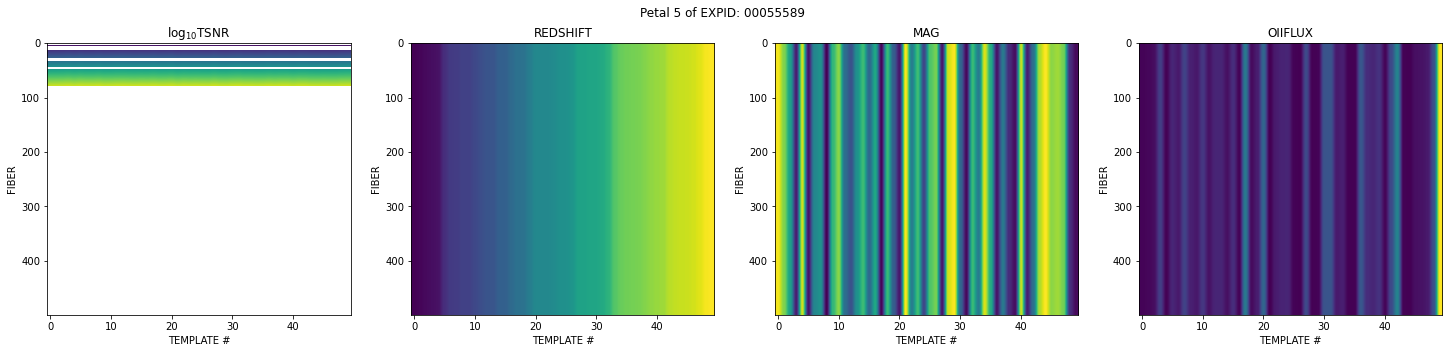

In [9]:
for nexp, expid in enumerate(expids):
    print('Solving for EXPID {:08d}'.format(expid))
    
    rads = RadLSS(night, expid, cameras=cameras)
    
    rads.compute(tracers=tracers)

    if nexp == nmax:
        break

Text(0.5, 0.98, 'Petal 5 of EXPID: 00055589')

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/matplotlib/image.py:455: RuntimeWarning: overflow encountered in double_scalars
  newmin = vmid - dv * fact
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/matplotlib/image.py:460: RuntimeWarning: overflow encountered in double_scalars
  newmax = vmid + dv * fact


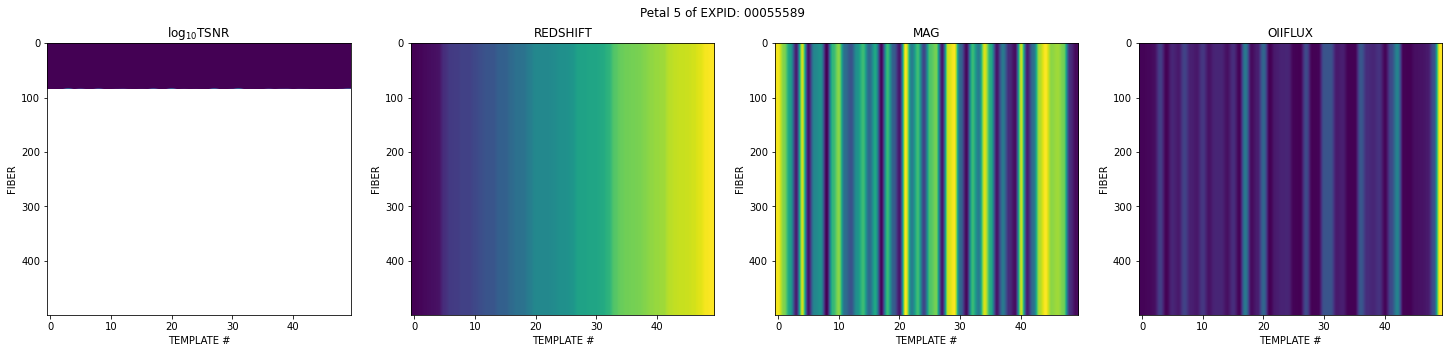

In [11]:
tracer    = 'ELG'
petal     = '5'

fig, axes = plt.subplots(1, 4, figsize=(25,5))

axes[0].imshow(rads.template_snrs[tracer]['brz{}'.format(petal)]['TSNR'], aspect='auto')

axes[1].imshow(np.broadcast_to(rads.ensemble_meta[tracer]['REDSHIFT'],   (500, rads.nmodel)), aspect='auto')
axes[2].imshow(np.broadcast_to(rads.ensemble_meta[tracer]['MAG'],        (500, rads.nmodel)), aspect='auto')
axes[3].imshow(np.broadcast_to(rads.ensemble_objmeta[tracer]['OIIFLUX'], (500, rads.nmodel)), aspect='auto')

axes[0].set_title('$\log_{10}$TSNR')
axes[1].set_title('REDSHIFT')
axes[2].set_title('MAG')
axes[3].set_title('OIIFLUX')

for ax in axes:
    ax.set_xlabel('TEMPLATE #')
    ax.set_ylabel('FIBER')

fig.suptitle('Petal {} of EXPID: {:08d}'.format(petal, rads.expid))

In [12]:
rads.template_snrs[tracer]['brz{}'.format(petal)]['TSNR']

array([[1.36630391e+03, 3.75588460e+03, 1.18883026e+04, ...,
        1.54239789e+03, 8.26882847e+04, 3.56803122e+05],
       [2.27865177e+06, 6.24546584e+06, 1.94383860e+07, ...,
        1.84945558e+06, 1.11298204e+08, 5.41601377e+08],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])

In [70]:
rads.gen_template_ensemble()

INFO:io.py:971:read_basis_templates: Reading /global/cfs/cdirs/desi/spectro/templates/basis_templates/v3.2/elg_templates_v2.2.fits
Rank 0:  Template ensemble in 0.279 mins.


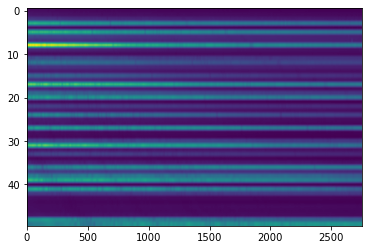

In [75]:
plt.imshow(rads.ensemble_flux['ELG']['b'], aspect='auto')

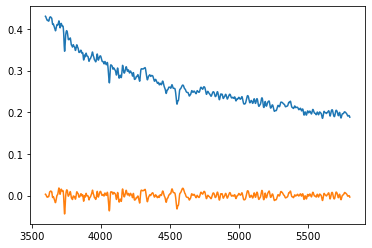

In [80]:
for ff in rads.ensemble_flux['ELG']['b']:
    pl.plot(rads.cframes['b5'].wave, ff)
    
    sflux = convolve(ff, Box1DKernel(125), boundary='extend')

    dflux = ff - sflux

    pl.plot(rads.cframes['b5'].wave, dflux)    
    
    break

In [69]:
! mkdir /global/cscratch1/sd/mjwilson/radlss/test//ensemble/

In [67]:
! rm -r /global/cscratch1/sd/mjwilson/radlss/test//ensemble/

In [53]:
rads.nmodel

50

# Done.